In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
df = pd.read_csv('data/cleaned/train.csv')
df.head()


,disrict,client_id,client_catg,region,target,transactions_count,most_frequ_reading_rem,mean_counter_coeff,mean_consommation_per_month,mean_months,elec_max,gaz_max
0,63,train_Client_33962,11,101,0.00,72,6.00,1.00,113.27,4.00,1,1
1,62,train_Client_32174,11,301,0.00,40,6.00,1.00,8.11,3.40,1,1
2,69,train_Client_18868,11,107,0.00,59,6.00,1.00,70.77,4.00,1,1
3,62,train_Client_39728,11,310,0.00,37,6.00,1.00,144.65,4.11,1,0
4,60,train_Client_34246,11,101,0.00,57,6.00,1.00,120.93,3.96,1,1


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id'], axis=1)

## Random Oversampler

<Axes: xlabel='target', ylabel='count'>

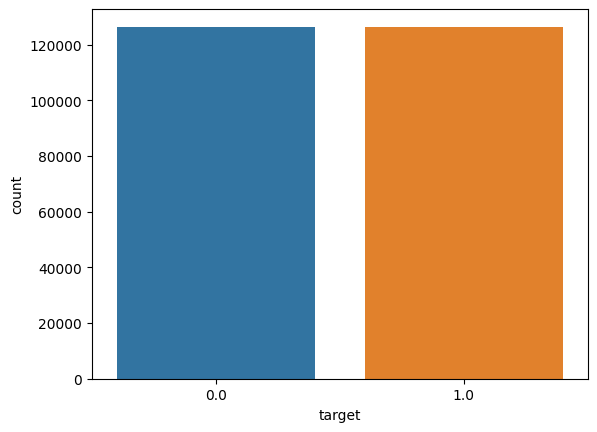

In [4]:
# handling the imbalanced
ros = RandomOverSampler(random_state=RSEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

sns.countplot(x=y_train)

## Baseline model
<span style="color:red">PREDICT with test-data!</span>

In [ ]:
#baseline model
baseline_tree = DecisionTreeClassifier(random_state=RSEED, max_depth=3)
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
print(f'Decision tree has {baseline_tree.tree_.node_count} nodes with maximum depth {baseline_tree.tree_.max_depth}.')
print(f'On average there are ca. {X_train.shape[0]/baseline_tree.tree_.node_count:.1f} data points in each leaf.')

Decision tree has 15 nodes with maximum depth 3.
On average there are ca. 16851.7 data points in each leaf.


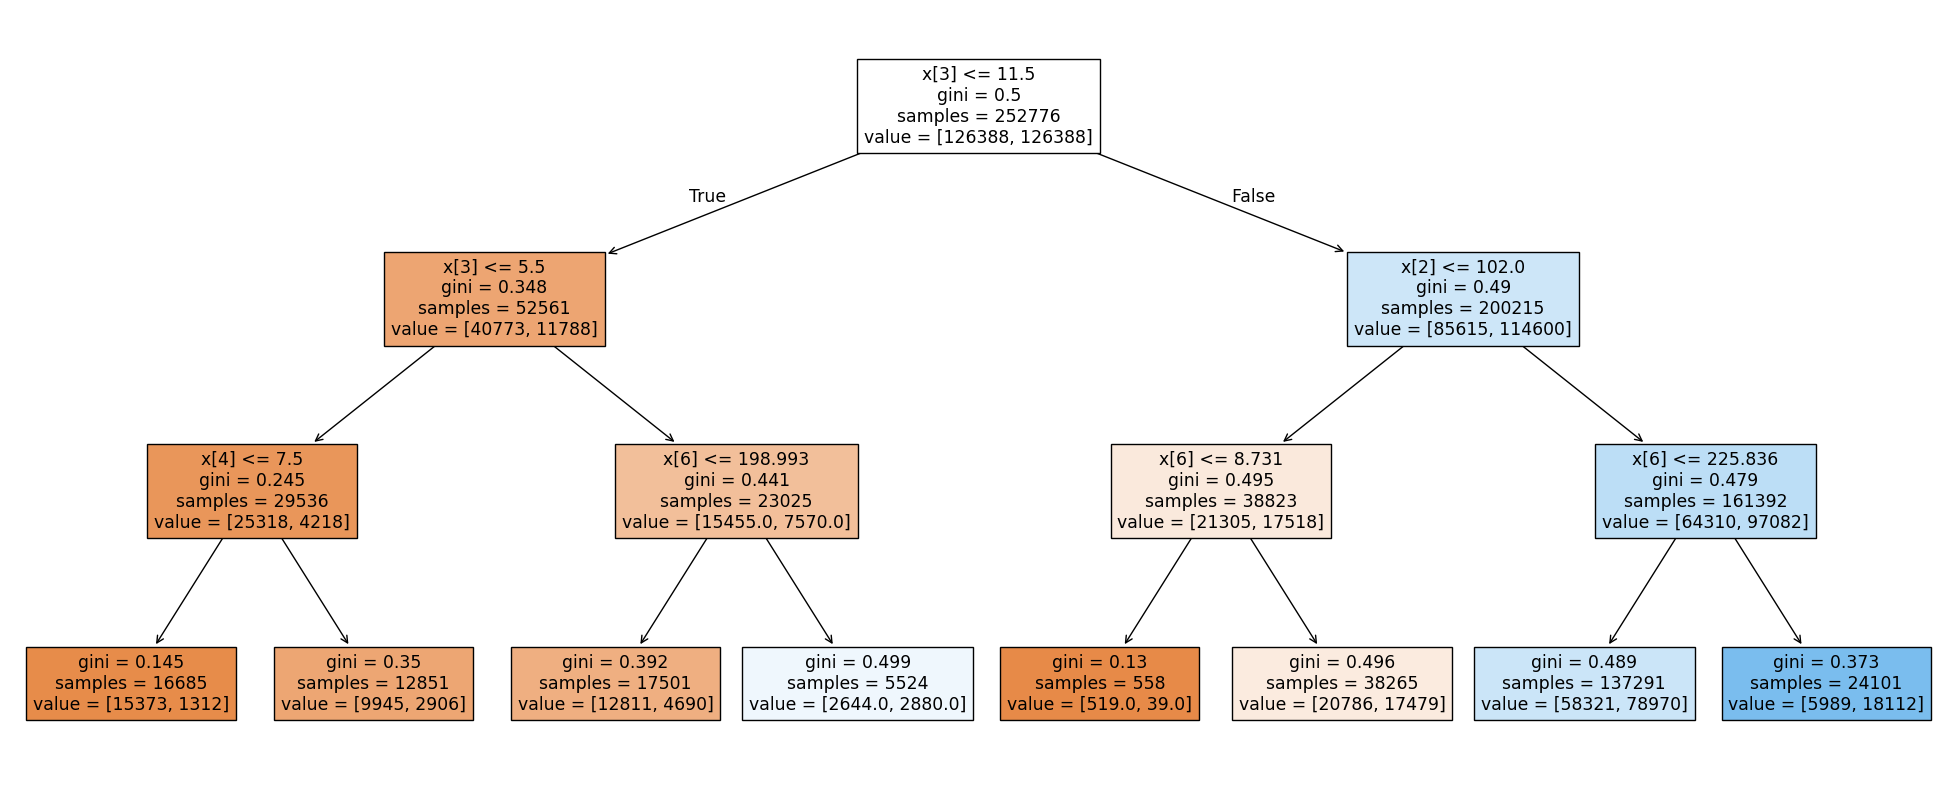

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,10))
dectree_plot = plot_tree(baseline_tree, filled=True)

In [ ]:
# Make probability predictions
train_probs = baseline_tree.predict_proba(X_train)[:, 1]
train_predictions = baseline_tree.predict(X_train)


In [9]:
from sklearn.metrics import roc_auc_score

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')


Train ROC AUC Score: 0.669515889223686


In [ ]:
# baseline 2: logistic Regression

baseline_log_reg = LogisticRegression(max_iter=1000, n_jobs=1)
baseline_log_reg.fit(X_train, y_train)

y_train_pred = baseline_log_reg.predict(X_train)



In [12]:
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[81291 45097]
 [50398 75990]]
              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63    126388
         1.0       0.63      0.60      0.61    126388

    accuracy                           0.62    252776
   macro avg       0.62      0.62      0.62    252776
weighted avg       0.62      0.62      0.62    252776

